# Tabular - Binary Classification using DNNs

By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of binary classification using feedforward networks on the [lower back pain symptoms dataset](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) using PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv("../../../data/tabular/classification/spine_dataset.csv")

## Pre-processing

In [4]:
df = df.iloc[:, 0:-1]

In [5]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [6]:
len(df)

310

In [7]:
df.describe()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


Output Count.

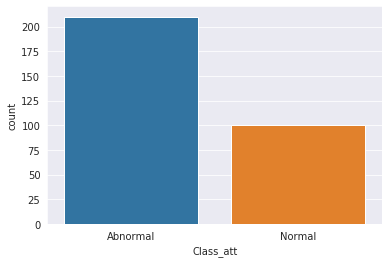

In [8]:
sns.countplot(x = 'Class_att', data=df)

In [9]:
df['Class_att'] = df['Class_att'].astype('category')

In [10]:
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [11]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Parameters

In [14]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.1

## Define Custom Dataloader

In [15]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [16]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

### Define Neural Net Architecture

In [17]:
class binaryClassification(nn.Module):
    def __init__(self, dropout, ):
        super(binaryClassification, self).__init__()
        
        self.layer_1 = nn.Linear(12, 64) # Number of input features is 12.
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
model = binaryClassification(dropout=DROPOUT)
model.to(device)

print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train 

In [20]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [29]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.04027 | Acc: 98.250
Epoch 002: | Loss: 0.12023 | Acc: 96.750
Epoch 003: | Loss: 0.02067 | Acc: 99.500
Epoch 004: | Loss: 0.07329 | Acc: 96.250
Epoch 005: | Loss: 0.04676 | Acc: 99.250
Epoch 006: | Loss: 0.03005 | Acc: 99.500
Epoch 007: | Loss: 0.05777 | Acc: 98.250
Epoch 008: | Loss: 0.03446 | Acc: 99.500
Epoch 009: | Loss: 0.03443 | Acc: 100.000
Epoch 010: | Loss: 0.03368 | Acc: 100.000
Epoch 011: | Loss: 0.02395 | Acc: 100.000
Epoch 012: | Loss: 0.05094 | Acc: 98.250
Epoch 013: | Loss: 0.03618 | Acc: 98.250
Epoch 014: | Loss: 0.02143 | Acc: 100.000
Epoch 015: | Loss: 0.02730 | Acc: 99.500
Epoch 016: | Loss: 0.02323 | Acc: 100.000
Epoch 017: | Loss: 0.03395 | Acc: 98.250
Epoch 018: | Loss: 0.08600 | Acc: 96.750
Epoch 019: | Loss: 0.02394 | Acc: 100.000
Epoch 020: | Loss: 0.02363 | Acc: 100.000
Epoch 021: | Loss: 0.01660 | Acc: 100.000
Epoch 022: | Loss: 0.05766 | Acc: 96.750
Epoch 023: | Loss: 0.02115 | Acc: 100.000
Epoch 024: | Loss: 0.01331 | Acc: 100.000
Epoch 

## Test

In [34]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

In [35]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix

In [36]:
confusion_matrix(y_test, y_pred_list)

array([[23,  8],
       [12, 60]])

### Classification Report

In [37]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        31
           1       0.88      0.83      0.86        72

    accuracy                           0.81       103
   macro avg       0.77      0.79      0.78       103
weighted avg       0.81      0.81      0.81       103

